In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings
from collections import Counter

In [27]:
import pandas as pd
import numpy as np
df_train_2022 = pd.read_csv('../data/2022/train_2022.csv')
df_train_2021 = pd.read_csv('../data/2021/train_2021.csv')
df_train_2020 = pd.read_csv('../data/2020/train_2020.csv')
df_train_2019 = pd.read_csv('../data/2019/train_2019.csv')
test_df = pd.read_csv('../data/2023/test.csv')

train_df = pd.DataFrame()
train_df = pd.concat([df_train_2022,df_train_2021,df_train_2020,df_train_2019],axis=0)

# train_df['nearest_price_pub'] = np.log1p(train_df['nearest_price_pub'])
# test_df['nearest_price_pub'] = np.log1p(test_df['nearest_price_pub'])

/tmp/ipykernel_6906/1347526976.py:3: DtypeWarning: Columns (40,43,47,56,57,64,119,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2022 = pd.read_csv('../data/2022/train_2022.csv')
/tmp/ipykernel_6906/1347526976.py:4: DtypeWarning: Columns (40,41,43,47,56,57,64,65,66,95,117,119,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2021 = pd.read_csv('../data/2021/train_2021.csv')
/tmp/ipykernel_6906/1347526976.py:5: DtypeWarning: Columns (43,47,56,57,64,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2020 = pd.read_csv('../data/2020/train_2020.csv')
/tmp/ipykernel_6906/1347526976.py:6: DtypeWarning: Columns (43,47,56,57,64,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2019 = pd.read_c

In [28]:
train_df['log_money_room'] = np.log1p(train_df['money_room']/train_df['house_area'])
y = train_df['log_money_room']
train_df['price_pub_nearest'] = np.log1p(train_df['price_pub_nearest'])
test_df['price_pub_nearest'] = np.log1p(test_df['price_pub_nearest'])
train_df['price_pub_mean_top5'] = np.log1p(train_df['price_pub_mean_top5'])
test_df['price_pub_mean_top5'] = np.log1p(test_df['price_pub_mean_top5'])
train_df['price_pub_median_top5'] = np.log1p(train_df['price_pub_median_top5'])
test_df['price_pub_median_top5'] = np.log1p(test_df['price_pub_median_top5'])
train_df['price_pub_min_top5'] = np.log1p(train_df['price_pub_min_top5'])
test_df['price_pub_min_top5'] = np.log1p(test_df['price_pub_min_top5'])
train_df['price_pub_max_top5'] = np.log1p(train_df['price_pub_max_top5'])
test_df['price_pub_max_top5'] = np.log1p(test_df['price_pub_max_top5'])

In [29]:
import yaml
class FeatureProcessor:
    """train/testで一貫した前処理を行うクラス"""
    
    def __init__(self):
        self.top_tags = {}  # タグカラムごとの頻出タグリスト
        self.label_encoders = {}  # カテゴリカラムごとのLabelEncoder
        self.median_built = None
        self.cat_cols = [
            'building_type', 'building_structure', 'floor_plan_code', 
            'prefecture', 'city', 'pub_land_use_mode_top5','pub_land_use_nearest','pub_land_shape_nearest','rosen_name1'
        ]
        with open("../data/UseCol.yml", "r", encoding="utf-8") as f:
            config = yaml.safe_load(f)
        self.use_cols = config["use"]
        self.tag_cols = []
        self.feature_cols = config["feature_col"]
        self.slashed_col = ["building_tag_id", "unit_tag_id","reform_interior", "reform_exterior", "reform_wet_area","statuses"]
    
    def get_slashed_tags(self,df):
        """スラッシュ区切りの値を持つ列を個別の列に変換する"""
        tag_master = pd.read_excel(f"../data/data_definition.xlsx",
                           sheet_name='③タグマスタ情報')
        tag_master = tag_master[['タグID', 'タグ内容']]
        tag_master["タグID"] = tag_master["タグID"].astype("str")
        tag_master.set_index('タグID', inplace=True)
        tag_master = tag_master.to_dict()['タグ内容']
        temp_dfs = []
        for col in self.slashed_col:
            temp_df = df[col].str.get_dummies(sep="/").astype("str")
            temp_df.rename(columns=tag_master, inplace=True)
            new_col_name = [f"{col} " + c for c in temp_df.columns]
            temp_df.columns = new_col_name
            temp_dfs.append(temp_df)
        temp_dfs = pd.concat(temp_dfs, axis=1)

        self.tag_cols += temp_dfs.columns.tolist()
        return temp_dfs
    
    def fit(self, df):
        """trainデータから変換ルールを学習"""
        df = df.copy()
        
        # 築年の中央値を記録
        self.median_built = df['year_built'].median()
        
        # LabelEncoderをfit
        df = self._extract_address(df)
        for col in self.cat_cols:
            if col in df.columns:
                self.label_encoders[col] = LabelEncoder()
                df[col] = df[col].astype(str).fillna('unknown')
                self.label_encoders[col].fit(df[col])
        
        return self
    
    def transform(self, df, is_train=True):
        """データを変換"""
        df = df.copy()
        
        # --- A. 日付・築年数処理 ---
        df['target_year'] = df['target_ym'] // 100
        df['target_month'] = df['target_ym'] % 100
        
        df['year_built'] = df['year_built'].fillna(self.median_built)
        df['built_year'] = df['year_built'] // 100
        df['built_month'] = df['year_built'] % 100
        
        df['building_age_months'] = (
            (df['target_year'] - df['built_year']) * 12 + 
            (df['target_month'] - df['built_month'])
        )
        df['building_age_months'] = df['building_age_months'].clip(lower=0)
        
        
        # --- C. 住所からの抽出 ---
        df = self._extract_address(df)
        
        # --- D. カテゴリカル変数のエンコード ---
        for col in self.cat_cols:
            if col in df.columns and col in self.label_encoders:
                df[col] = df[col].astype(str).fillna('unknown')
                le = self.label_encoders[col]
                known_classes = set(le.classes_)
                # 既知ならエンコード、未知なら-1
                df[col] = df[col].apply(
                    lambda x: le.transform([x])[0] if x in known_classes else -1
                )
        
        # --- E. 使用するカラムを選定 ---
        with open("../data/UseCol.yml", "r", encoding="utf-8") as f:
            config = yaml.safe_load(f)
        
        use_cols = config["feature_col"]
        use_cols += ['prefecture','city','building_age_months','target_year','target_month']
        # タグフラグも追加
        use_cols += self.tag_cols
        self.feature_cols = set(use_cols)
        
        return df[list(self.feature_cols)]
    
    def fit_transform(self, df):
        """fitとtransformを同時に実行"""
        self.fit(df)
        return self.transform(df, is_train=True)
    
    def _extract_address(self, df):
        """住所から都道府県・市区町村を抽出"""
        df['prefecture'] = df['full_address'].str.extract(r'([^都道府県]+[都道府県])')
        df['city'] = df['full_address'].str.extract(r'[都道府県]([^市区町村]+[市区町村])')
        return df

In [30]:
# 前処理実行
processor = FeatureProcessor()

In [31]:
train_df = train_df[processor.use_cols]
test_df = test_df[processor.use_cols]

In [32]:
combined_df = pd.concat([train_df, test_df],axis=0)
slashed_df = processor.get_slashed_tags(combined_df)

In [33]:
# 新しく生成された列名を保存
tag_columns = slashed_df.columns
# 抽出した特徴量を結合
combined_df = pd.concat([combined_df, slashed_df], axis=1)

In [34]:
# trainとtestに分割
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [35]:
print(len(train_df.columns))
print(len(test_df.columns))

476
476


In [36]:
# 前処理実行
X_train = processor.fit_transform(train_df)
X_test = processor.transform(test_df, is_train=False)


In [37]:
set(X_test.columns.to_list())-set(X_train.columns.tolist())

set()

In [38]:
print(len(X_test.columns.to_list()))
print(len(X_train.columns.to_list()))

474
474


In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363924 entries, 0 to 82290
Columns: 474 entries, unit_tag_id 保証付住宅 to unit_tag_id 家具・家電付
dtypes: float64(83), int64(13), object(378)
memory usage: 1.3+ GB


In [40]:
for col in X_train.select_dtypes(include='object').columns:
    try:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    except Exception as e:
        print(f"カラム '{col}' の変換に失敗: {e}")

In [41]:
for col in X_test.select_dtypes(include='object').columns:
    try:
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    except Exception as e:
        print(f"カラム '{col}' の変換に失敗: {e}")

In [ ]:
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback

# 東京都かどうかを判定する列を追加（元のtrain_dfを使用）
# prefectureの情報を取得
train_prefecture = processor.transform(train_df, is_train=True)['prefecture']
test_prefecture = processor.transform(test_df, is_train=False)['prefecture']

# 東京都のインデックスを取得（東京都はLabelEncoderでエンコードされている）
tokyo_label = processor.label_encoders['prefecture'].transform(['東京都'])[0] if '東京都' in processor.label_encoders['prefecture'].classes_ else -1

# 東京都とそれ以外に分離
is_tokyo_train = (train_prefecture == tokyo_label).values
is_tokyo_test = (test_prefecture == tokyo_label).values

print(f"訓練データ: 東京都={is_tokyo_train.sum()}, それ以外={(~is_tokyo_train).sum()}")
print(f"テストデータ: 東京都={is_tokyo_test.sum()}, それ以外={(~is_tokyo_test).sum()}")

# Optunaによるハイパーパラメータチューニング関数
def objective(trial, X, y, is_tokyo=False):
    """Optunaの目的関数"""
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_val],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=0)
            ]
        )
        
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

from sklearn.metrics import mean_squared_error

# 東京都用のハイパーパラメータチューニング
print("\n=== 東京都モデルのハイパーパラメータチューニング ===")
X_train_tokyo = X_train[is_tokyo_train]
y_tokyo = y[is_tokyo_train]

study_tokyo = optuna.create_study(direction='minimize', study_name='tokyo_lgb')
study_tokyo.optimize(lambda trial: objective(trial, X_train_tokyo, y_tokyo, is_tokyo=True), 
                      n_trials=50, show_progress_bar=True)

print(f"\n東京都モデル Best RMSE: {study_tokyo.best_value:.4f}")
print(f"Best params: {study_tokyo.best_params}")

# それ以外用のハイパーパラメータチューニング
print("\n=== それ以外モデルのハイパーパラメータチューニング ===")
X_train_other = X_train[~is_tokyo_train]
y_other = y[~is_tokyo_train]

study_other = optuna.create_study(direction='minimize', study_name='other_lgb')
study_other.optimize(lambda trial: objective(trial, X_train_other, y_other, is_tokyo=False), 
                      n_trials=50, show_progress_bar=True)

print(f"\nそれ以外モデル Best RMSE: {study_other.best_value:.4f}")
print(f"Best params: {study_other.best_params}")

In [ ]:
# 最適化されたパラメータで東京都モデルを訓練
print("\n=== 東京都モデルの訓練 ===")
best_params_tokyo = study_tokyo.best_params
best_params_tokyo.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42
})

folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds_tokyo = np.zeros(len(X_train_tokyo))
test_preds_tokyo = np.zeros(is_tokyo_test.sum())
models_tokyo = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X_train_tokyo, y_tokyo)):
    X_tr, y_tr = X_train_tokyo.iloc[train_idx], y_tokyo.iloc[train_idx]
    X_val, y_val = X_train_tokyo.iloc[val_idx], y_tokyo.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        best_params_tokyo,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=500)
        ]
    )
    
    oof_preds_tokyo[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    
    # テストデータの予測（東京都のみ）
    X_test_tokyo = X_test[is_tokyo_test]
    test_preds_tokyo += model.predict(X_test_tokyo, num_iteration=model.best_iteration) / folds.n_splits
    
    models_tokyo.append(model)
    print(f"Fold {fold+1} RMSE: {model.best_score['valid_1']['rmse']:.4f}")

# 東京都モデルの全体評価
tokyo_rmse = np.sqrt(mean_squared_error(y_tokyo, oof_preds_tokyo))
print(f"\n東京都モデル Overall RMSE: {tokyo_rmse:.4f}")

# 最適化されたパラメータでそれ以外モデルを訓練
print("\n=== それ以外モデルの訓練 ===")
best_params_other = study_other.best_params
best_params_other.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42
})

oof_preds_other = np.zeros(len(X_train_other))
test_preds_other = np.zeros((~is_tokyo_test).sum())
models_other = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X_train_other, y_other)):
    X_tr, y_tr = X_train_other.iloc[train_idx], y_other.iloc[train_idx]
    X_val, y_val = X_train_other.iloc[val_idx], y_other.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        best_params_other,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=500)
        ]
    )
    
    oof_preds_other[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    
    # テストデータの予測（それ以外のみ）
    X_test_other = X_test[~is_tokyo_test]
    test_preds_other += model.predict(X_test_other, num_iteration=model.best_iteration) / folds.n_splits
    
    models_other.append(model)
    print(f"Fold {fold+1} RMSE: {model.best_score['valid_1']['rmse']:.4f}")

# それ以外モデルの全体評価
other_rmse = np.sqrt(mean_squared_error(y_other, oof_preds_other))
print(f"\nそれ以外モデル Overall RMSE: {other_rmse:.4f}")

# 全体の予測を結合
test_preds = np.zeros(len(X_test))
test_preds[is_tokyo_test] = test_preds_tokyo
test_preds[~is_tokyo_test] = test_preds_other

print(f"\n全体の予測完了")
print(f"東京都テストデータ数: {is_tokyo_test.sum()}")
print(f"それ以外テストデータ数: {(~is_tokyo_test).sum()}")

In [ ]:
# ---------------------------------------------------------
# 4. 結果評価と特徴量重要度
# ---------------------------------------------------------

# 東京都モデルの特徴量重要度
print("=== 東京都モデルの特徴量重要度 ===")
importance_df_tokyo = pd.DataFrame({
    'feature': X_train_tokyo.columns,
    'importance': np.mean([m.feature_importance(importance_type='gain') for m in models_tokyo], axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features (東京都):")
print(importance_df_tokyo.head(10).to_string(index=False))

# それ以外モデルの特徴量重要度
print("\n=== それ以外モデルの特徴量重要度 ===")
importance_df_other = pd.DataFrame({
    'feature': X_train_other.columns,
    'importance': np.mean([m.feature_importance(importance_type='gain') for m in models_other], axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features (それ以外):")
print(importance_df_other.head(10).to_string(index=False))

In [ ]:
# ---------------------------------------------------------
# 5. 予測結果の出力
# ---------------------------------------------------------
# 対数を戻して実際の価格に変換
test_df['predicted_money_room'] = np.expm1(test_preds)
test_df1 = pd.read_csv('../data/2023/test.csv')
# 提出用ファイルの作成（必要なカラムに応じて調整）
submission = pd.DataFrame({
    'id': test_df.index if 'id' not in test_df.columns else test_df['id'],
    'money_room': test_df['predicted_money_room'] * test_df1['house_area']
})
submission.to_csv('../data/submission.csv', index=False)

print(f"\nPrediction saved to submission.csv")
print(f"Prediction stats:")
print(f"  Min: {submission['money_room'].min():,.0f} JPY")
print(f"  Max: {submission['money_room'].max():,.0f} JPY")
print(f"  Mean: {submission['money_room'].mean():,.0f} JPY")

/tmp/ipykernel_6906/3771505139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_money_room'] = np.expm1(test_preds)
/tmp/ipykernel_6906/3771505139.py:6: DtypeWarning: Columns (41,44,48,57,58,65,148,161,195,229,263,297,331,365,399,433,467) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df1 = pd.read_csv('../data/2023/test.csv')



Prediction saved to submission.csv
Prediction stats:
  Min: -124 JPY
  Max: 3,678,992,719 JPY
  Mean: 24,540,379 JPY


In [22]:
import pandas as pd
importance = pd.DataFrame()
importance['feature'] = X_train.columns
importance['gain'] = models[0].feature_importance(importance_type='gain')
print("\nTop 10 Important Features:")
print(importance.sort_values(by='gain', ascending=False).head(10))


Top 10 Important Features:
                   feature           gain
367              unit_area  177438.261377
381             year_built  165584.246548
74      price_pub_min_top5   80486.425569
347      price_pub_nearest   70775.224677
64   price_pub_median_top5   59174.282475
371    price_pub_mean_top5   53271.782176
202    building_age_months   19154.309646
223                    lon   18345.518280
399         statuses 浴室乾燥機   17590.366351
377               RTC_2050   16478.918273


ImportError: You must install graphviz and restart your session to plot tree.

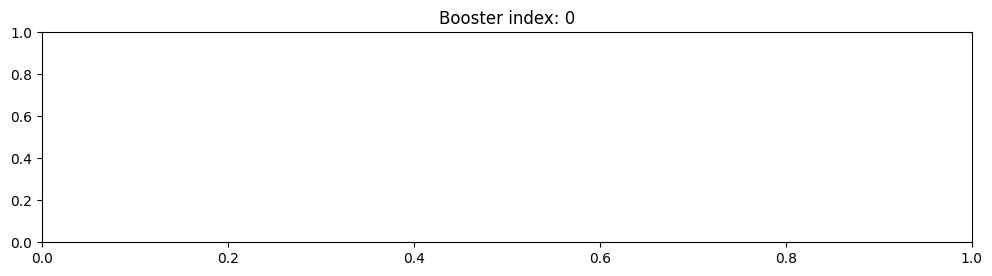

In [25]:
import matplotlib.pyplot as plt
rows = 2
cols = 1
fig = plt.figure(figsize=(12, 6))
for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(f'Booster index: {i}')
    lgb.plot_tree(booster=models[0],
                    tree_index=i,
                    show_info='internal_value',
                    ax=ax,
                    )
plt.show()